In [1]:
from pylearn2.utils.serial import load as load_model
from pylearn2.gui.get_weights_report import get_weights_report
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os.path
import io
from IPython.display import display, Image

Using gpu device 0: Tesla K20c


In [31]:
model = load_model(os.path.expandvars('${DATA_DIR}/plankton/models/3_conv_2_fc_96c_h1_resume_recent.pkl'))

## Model summary
Run done with model with three convolutional layers, two fully connected layers and a final softmax layer, with 64 channels per convolutional layer in first two layers and 48 in final. Fully connected layers have 512 units each. Dropout applied in first (larger) fully connected layer (dropout probability 0.5) and random augmentation of dataset with uniform random rotations, shunting and scaling.

In [4]:
print('## Model structure summary\n')
print(model)
params = model.get_params() 
n_params = {p.name : p.get_value().size for p in params}
total_params = sum(n_params.values())
print('\n## Number of parameters\n')
print('  ' + '\n  '.join(['{0} : {1} ({2:.1f}%)'.format(k, v, 100.*v/total_params) 
                          for k, v in sorted(n_params.items(), key=lambda x: x[0])]))
print('\nTotal : {0}'.format(total_params))

## Model structure summary

h1
	Input space: Conv2DSpace(shape=(64, 64), num_channels=1, axes=('b', 0, 1, 'c'), dtype=float32)
	Total input dimension: 4096
h2
	Input space: Conv2DSpace(shape=(34, 34), num_channels=96, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 110976
h3
	Input space: Conv2DSpace(shape=(18, 18), num_channels=96, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 31104
h4
	Input space: Conv2DSpace(shape=(10, 10), num_channels=48, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 4800
h5
	Input space: VectorSpace(dim=512, dtype=float32)
	Total input dimension: 512
y
	Input space: VectorSpace(dim=512, dtype=float32)
	Total input dimension: 512

## Number of parameters

  h1_W : 2400 (0.1%)
  h1_b : 443904 (12.7%)
  h2_W : 82944 (2.4%)
  h2_b : 124416 (3.6%)
  h3_W : 41472 (1.2%)
  h3_b : 19200 (0.5%)
  h4_W : 2457600 (70.3%)
  h4_b : 512 (0.0%)
  h5_W : 262144 (7.5%)
  h5_b : 512 (0.0%)
  softmax_W : 61952 (1.8%)
  softmax_b : 121 

## Train and valid set NLL trace 

Minimum validation set NLL 0.832531571388


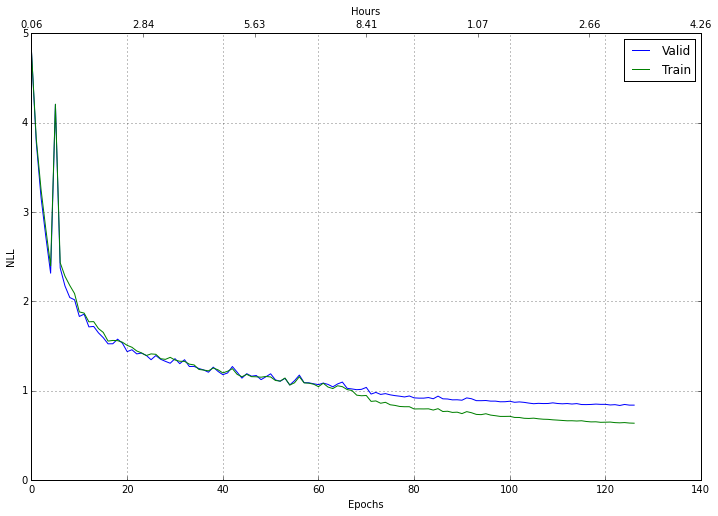

In [32]:
tr = np.array(model.monitor.channels['valid_y_y_1_nll'].time_record) / 3600.
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax1.plot(model.monitor.channels['valid_y_y_1_nll'].val_record)
ax1.plot(model.monitor.channels['train_y_y_1_nll'].val_record)
ax1.set_xlabel('Epochs')
ax1.legend(['Valid', 'Train'])
ax1.set_ylabel('NLL')
ax1.set_ylim(0., 5.)
ax1.grid(True)
ax2 = ax1.twiny()
ax2.set_xticks(np.arange(0,tr.shape[0],20))
ax2.set_xticklabels(['{0:.2f}'.format(t) for t in tr[::20]])
ax2.set_xlabel('Hours')
print("Minimum validation set NLL {0}".format(min(model.monitor.channels['valid_y_y_1_nll'].val_record)))

## Visualising first layer weights
Quite nice features appear to have been learned with some kernels appearing to have been learned at various rotations. Some quite small scale features appear to have been learned too.

smallest enc weight magnitude: 4.8225709179e-05
mean enc weight magnitude: 0.0990952551365
max enc weight magnitude: 0.779110431671


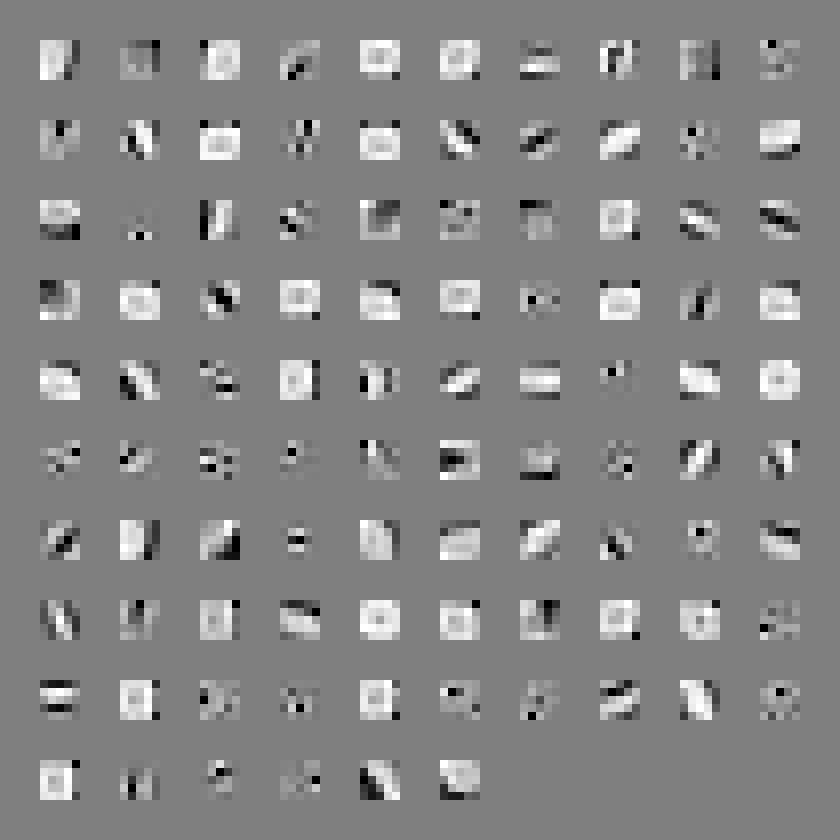

In [33]:
pv = get_weights_report(model=model)
img = pv.get_img()
img = img.resize((8*img.size[0], 8*img.size[1]))
img_data = io.BytesIO()
img.save(img_data, format='png')
display(Image(data=img_data.getvalue(), format='png'))

## Learning rate

Initially linear decay learning rate schedule used with monitor based adjuster. Turns out these don't play well together as the linear decay schedule overwrites any adjusments by monitor based extension at the next epoch. After resume initial learning rate manually reduced and learning rate schedule set exclusively with monitor based adjuster.

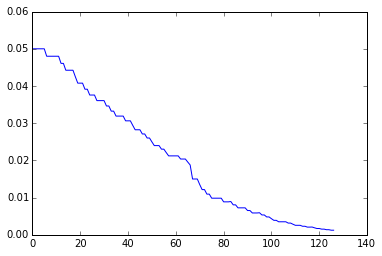

In [34]:
plt.plot(model.monitor.channels['learning_rate'].val_record)

## Update norm monitoring
Ratio of update norms to parameter norms across epochs for different layers plotted to give idea of how learning rate schedule performing.

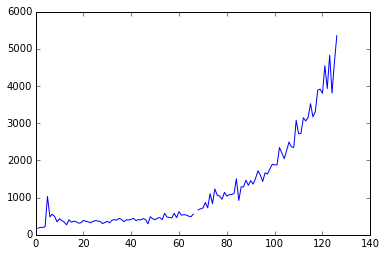

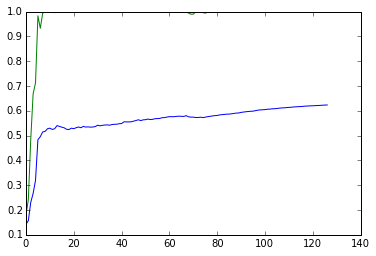

In [36]:
h1_W_up_norms = np.array([float(v) for v in model.monitor.channels['mean_update_h1_W_kernel_norm_mean'].val_record])
h1_W_norms = np.array([float(v) for v in model.monitor.channels['valid_h1_kernel_norms_mean'].val_record])
plt.plot(h1_W_norms / h1_W_up_norms)
plt.show()
plt.plot(model.monitor.channels['valid_h1_kernel_norms_mean'].val_record)
plt.plot(model.monitor.channels['valid_h1_kernel_norms_max'].val_record)

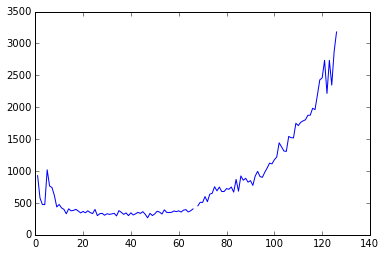

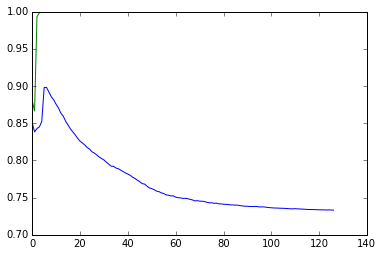

In [37]:
h2_W_up_norms = np.array([float(v) for v in model.monitor.channels['mean_update_h2_W_kernel_norm_mean'].val_record])
h2_W_norms = np.array([float(v) for v in model.monitor.channels['valid_h2_kernel_norms_mean'].val_record])
plt.plot(h2_W_norms / h2_W_up_norms)
plt.show()
plt.plot(model.monitor.channels['valid_h2_kernel_norms_mean'].val_record)
plt.plot(model.monitor.channels['valid_h2_kernel_norms_max'].val_record)

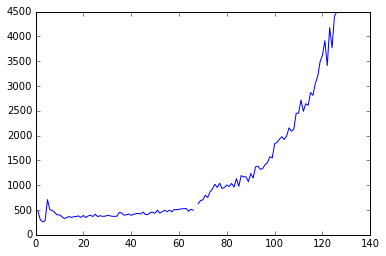

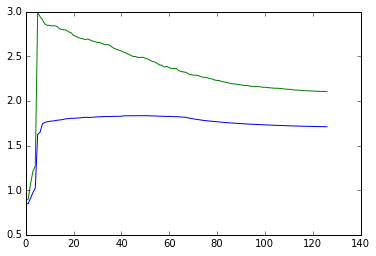

In [38]:
h3_W_up_norms = np.array([float(v) for v in model.monitor.channels['mean_update_h3_W_kernel_norm_mean'].val_record])
h3_W_norms = np.array([float(v) for v in model.monitor.channels['valid_h3_kernel_norms_mean'].val_record])
plt.plot(h3_W_norms / h3_W_up_norms)
plt.show()
plt.plot(model.monitor.channels['valid_h3_kernel_norms_mean'].val_record)
plt.plot(model.monitor.channels['valid_h3_kernel_norms_max'].val_record)

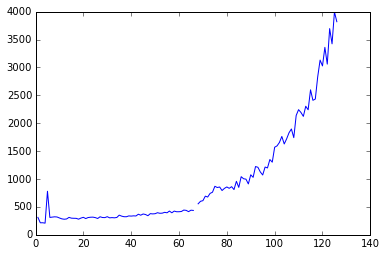

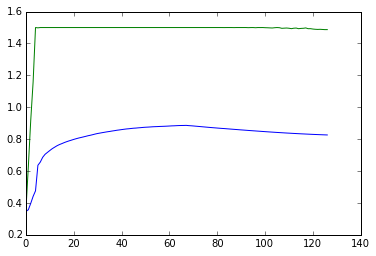

In [39]:
h4_W_up_norms = np.array([float(v) for v in model.monitor.channels['mean_update_h4_W_col_norm_mean'].val_record])
h4_W_norms = np.array([float(v) for v in model.monitor.channels['valid_h4_col_norms_mean'].val_record])
plt.plot(h4_W_norms / h4_W_up_norms)
plt.show()
plt.plot(model.monitor.channels['valid_h4_col_norms_mean'].val_record)
plt.plot(model.monitor.channels['valid_h4_col_norms_max'].val_record)

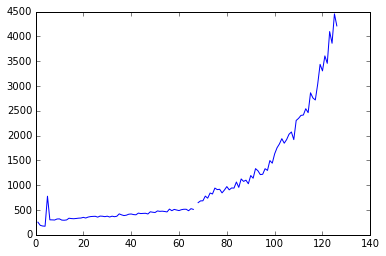

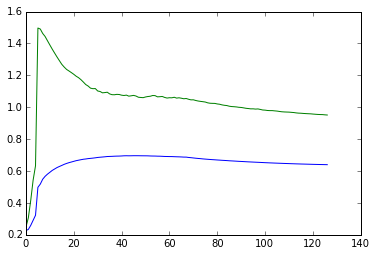

In [40]:
h5_W_up_norms = np.array([float(v) for v in model.monitor.channels['mean_update_h5_W_col_norm_mean'].val_record])
h5_W_norms = np.array([float(v) for v in model.monitor.channels['valid_h5_col_norms_mean'].val_record])
plt.plot(h5_W_norms / h5_W_up_norms)
plt.show()
plt.plot(model.monitor.channels['valid_h5_col_norms_mean'].val_record)
plt.plot(model.monitor.channels['valid_h5_col_norms_max'].val_record)